In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 113)

In [29]:
y_train.shape

(100, 2)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 2)                 34    

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [36]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 1s 4ms/step - loss: 0.7325 - rmse: 0.8559 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.4868 - rmse: 0.6977 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.2182 - rmse: 0.4672 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.1321 - rmse: 0.3635 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0818 - rmse: 0.2860 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0744 - rmse: 0.2728 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0482 - rmse: 0.2195 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0353 - rmse: 0.1878 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0293 - rmse: 0.1712 - lr: 0.0010
Epoch 10/5000
5/5 [==================

Epoch 77/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0064 - rmse: 0.0800 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0065 - rmse: 0.0806 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0059 - rmse: 0.0770 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0058 - rmse: 0.0761 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0070 - rmse: 0.0835 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0066 - rmse: 0.0813 - lr: 0.0010
Epoch 83/5000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - rmse: 0.0721 - lr: 0.0010
Epoch 84/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0061 - rmse: 0.0778 - lr: 0.0010
Epoch 85/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0079 - rmse: 0.0891 - lr: 0.0010
Epoch 86/5000
5/5 [=========

5/5 [==============================] - 0s 3ms/step - loss: 7.2446e-04 - rmse: 0.0269 - lr: 0.0010
Epoch 152/5000
5/5 [==============================] - 0s 3ms/step - loss: 6.3229e-04 - rmse: 0.0251 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.6436e-04 - rmse: 0.0191 - lr: 0.0010
Epoch 154/5000
5/5 [==============================] - 0s 3ms/step - loss: 3.8820e-04 - rmse: 0.0197 - lr: 0.0010
Epoch 155/5000
5/5 [==============================] - 0s 3ms/step - loss: 6.2289e-04 - rmse: 0.0250 - lr: 0.0010
Epoch 156/5000
5/5 [==============================] - 0s 3ms/step - loss: 7.3389e-04 - rmse: 0.0271 - lr: 0.0010
Epoch 157/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0013 - rmse: 0.0360 - lr: 0.0010
Epoch 158/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - rmse: 0.0410 - lr: 0.0010
Epoch 159/5000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - rmse: 0.0600 - lr: 0.0010
Epoch 160/

5/5 [==============================] - 0s 4ms/step - loss: 1.1731e-04 - rmse: 0.0108 - lr: 0.0010
Epoch 225/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1205e-05 - rmse: 0.0096 - lr: 0.0010
Epoch 226/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.4769e-05 - rmse: 0.0092 - lr: 0.0010
Epoch 227/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1173e-05 - rmse: 0.0095 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0542e-04 - rmse: 0.0103 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0456e-04 - rmse: 0.0102 - lr: 0.0010
Epoch 230/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0464e-04 - rmse: 0.0102 - lr: 0.0010
Epoch 231/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1349e-04 - rmse: 0.0107 - lr: 0.0010
Epoch 232/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.0638e-05 - rmse: 0.0084 - lr: 0.001

5/5 [==============================] - 0s 4ms/step - loss: 3.3564e-04 - rmse: 0.0183 - lr: 0.0010
Epoch 297/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.6346e-04 - rmse: 0.0191 - lr: 0.0010
Epoch 298/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.7671e-04 - rmse: 0.0194 - lr: 0.0010
Epoch 299/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.5250e-04 - rmse: 0.0235 - lr: 0.0010
Epoch 300/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.3989e-04 - rmse: 0.0253 - lr: 0.0010
Epoch 301/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.0256e-04 - rmse: 0.0265 - lr: 0.0010
Epoch 302/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.5329e-04 - rmse: 0.0256 - lr: 0.0010
Epoch 303/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.4963e-04 - rmse: 0.0274 - lr: 0.0010
Epoch 304/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.4967e-04 - rmse: 0.0274 - lr: 0.001

5/5 [==============================] - 0s 4ms/step - loss: 2.3685e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 368/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.2683e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 369/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.1212e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 370/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1843e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 371/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.4822e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 372/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.3473e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 373/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.5273e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 374/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1667e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 375/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.220

5/5 [==============================] - 0s 5ms/step - loss: 1.4240e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 438/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4821e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 439/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3088e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 440/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2108e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 441/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2974e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 442/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1909e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 443/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2610e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 444/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.1408e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 445/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.203

5/5 [==============================] - 0s 4ms/step - loss: 1.0335e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 508/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1546e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 509/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0218e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 510/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.8652e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 511/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1951e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 512/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1005e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 513/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5099e-05 - rmse: 0.0039 - lr: 5.0000e-04
Epoch 514/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4406e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 515/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.671

5/5 [==============================] - 0s 4ms/step - loss: 7.0443e-06 - rmse: 0.0027 - lr: 5.0000e-04
Epoch 578/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.8819e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 579/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.8381e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 580/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.5990e-06 - rmse: 0.0031 - lr: 5.0000e-04
Epoch 581/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4580e-05 - rmse: 0.0038 - lr: 5.0000e-04
Epoch 582/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2466e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 583/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.2265e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 584/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.2813e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 585/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.168

5/5 [==============================] - 0s 5ms/step - loss: 8.7736e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 648/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.3688e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 649/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.9794e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 650/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5508e-05 - rmse: 0.0039 - lr: 5.0000e-04
Epoch 651/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3367e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 652/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0918e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 653/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.0310e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 654/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.8509e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 655/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.489

5/5 [==============================] - 0s 5ms/step - loss: 4.5078e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 718/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.2598e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 719/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.5318e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 720/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.3508e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 721/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.8627e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 722/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.3313e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 723/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.6881e-05 - rmse: 0.0041 - lr: 5.0000e-04
Epoch 724/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.9537e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 725/5000
5/5 [==============================] - 0s 5ms/step - loss: 4.071

Epoch 786/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.9115e-05 - rmse: 0.0054 - lr: 2.5000e-04
Epoch 787/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.6711e-05 - rmse: 0.0041 - lr: 2.5000e-04
Epoch 788/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2758e-05 - rmse: 0.0036 - lr: 2.5000e-04
Epoch 789/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.5028e-05 - rmse: 0.0039 - lr: 2.5000e-04
Epoch 790/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.3402e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 791/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.5093e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 792/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0638e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 793/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.9684e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 794/5000
5/5 [==============================] - 0s 5ms/ste

In [37]:
time = end - start
print("Training time:", time)

Training time: 0:00:18.859048


In [38]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120MLP_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

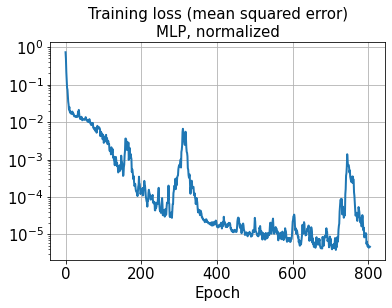

In [39]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

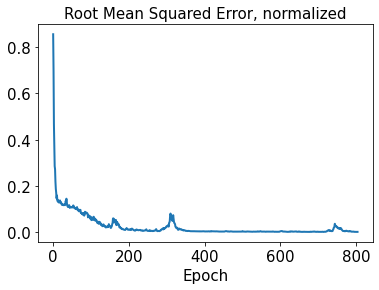

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

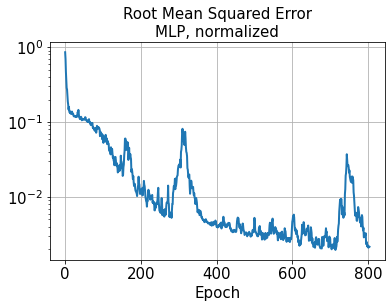

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [42]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 3.5488e-06 - rmse: 0.0019


In [43]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 1.5280e-04 - rmse: 0.0124


In [44]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [45]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0021348236135898687


In [50]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.015640502745739485


In [51]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.025874491707433687


In [52]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.00190327967054949


In [53]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.058392258246047865


In [54]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.015529228714422342


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [57]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [58]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [59]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [60]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

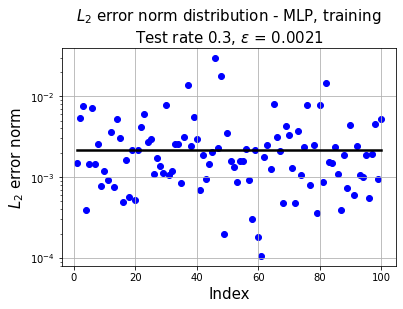

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

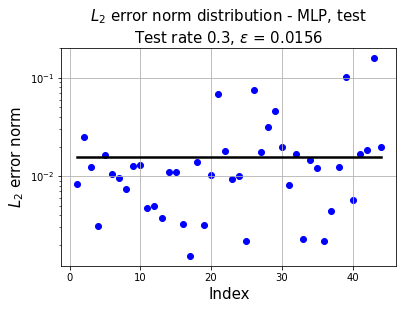

In [62]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

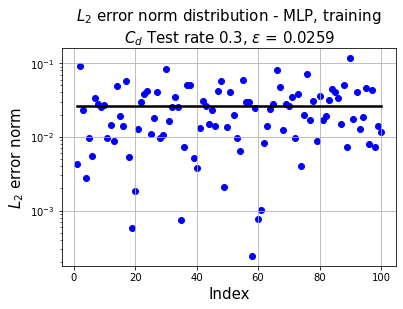

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

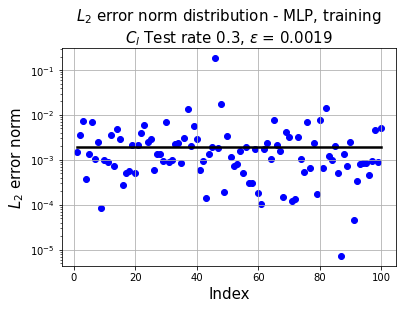

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

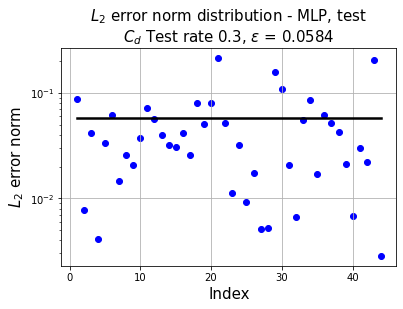

In [65]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

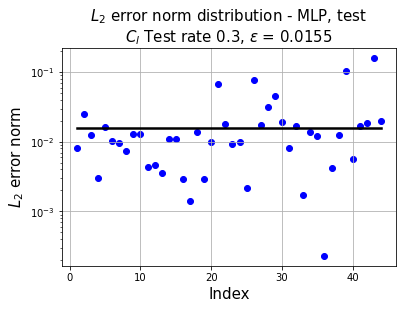

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()